In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.stats import LombScargle

In [3]:
import tensorflow as tf

session = tf.get_default_session()
if session is None:
    session = tf.InteractiveSession()

/Users/dforeman/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# These functions are used to transform bounded parameters to parameters to parameters with infinite range
def get_param_for_value(value, min_value, max_value):
    if np.any(value <= min_value) or np.any(value >= max_value):
        raise ValueError("value must be in the range (min_value, max_value)")
    return np.log(value - min_value) - np.log(max_value - value)

def get_value_for_param(param, min_value, max_value):
    return min_value + (max_value - min_value) / (1.0 + np.exp(-param))

def get_bounded_variable(name, value, min_value, max_value, dtype=tf.float64):
    param = tf.Variable(get_param_for_value(value, min_value, max_value), dtype=dtype, name=name + "_param")
    var = min_value + (max_value - min_value) / (1.0 + tf.exp(-param))
    log_jacobian = tf.log(var - min_value) + tf.log(max_value - var) - np.log(max_value - min_value)
    return param, var, tf.reduce_sum(log_jacobian), (min_value, max_value)

# This function constrains a pair of parameters to be a unit vector
def get_unit_vector(name, x_value, y_value, dtype=tf.float64):
    x_param = tf.Variable(x_value, dtype=dtype, name=name + "_x_param")
    y_param = tf.Variable(y_value, dtype=dtype, name=name + "_y_param")
    norm = tf.square(x_param) + tf.square(y_param)
    log_jacobian = -0.5*tf.reduce_sum(norm)
    norm = tf.sqrt(norm)
    x = x_param / norm
    y = y_param / norm
    return x_param, y_param, x, y, log_jacobian

In [25]:
np.random.seed(42)
t = np.linspace(0, 6, 5000)[:3000]
yerr = 0.1 + np.zeros_like(t)
ivar = 1.0 / yerr**2

T = tf.float64

log_prior = tf.constant(0.0, dtype=T)
nl = 2
nn = 3
nmodes = (2*nn+1)*nl

# The peak power is a nu_max
log_numax_param, log_numax, log_jac, log_numax_range = get_bounded_variable("log_numax", np.log(200.0), np.log(150.0), np.log(300.0), dtype=T)
log_prior += log_jac

# The highest frequency for mode l is at nu_max_l
log_numax_l_param, log_numax_l, log_jac, log_numax_l_range = get_bounded_variable("log_numax_l", np.log(200.0) + np.zeros(nl), np.log(150.0), np.log(300.0), dtype=T)
log_prior += log_jac

# Frequency spacing
log_dnu_param, log_dnu, log_jac, log_dnu_range = get_bounded_variable("log_dnu", np.log(17.0), np.log(15.0), np.log(30.0), dtype=T)
log_prior += log_jac

# The phase for each mode
cp, sp = np.random.randn(2, nmodes)
phi_x, phi_y, cosphi, sinphi, log_jac = get_unit_vector("phi", cp, sp, dtype=T)
log_prior += log_jac
phi = tf.atan2(sinphi, cosphi)

# The parameters of the envelope
log_amp_param, log_amp, log_jac, log_amp_range = get_bounded_variable("log_amp", np.log(np.random.uniform(0.015, 0.02, nl)), np.log(0.01), np.log(0.03), dtype=T)
log_prior += log_jac
log_width = tf.Variable(np.log(25.0), dtype=T, name="log_width")
curve = tf.Variable(0.001, dtype=T, name="curve")

# Initialize
session.run(tf.global_variables_initializer())

# Define the frequency comb
dn = np.arange(-nn, nn+1)
l = np.arange(nl)
numax = tf.exp(log_numax)
numax_l = tf.exp(log_numax_l)
dnu = tf.exp(log_dnu)
nu = (numax_l + 0.5*l*dnu)[:, None] + dnu*(dn + curve*dn**2)[None, :]
amp = tf.exp(log_amp[:, None]-0.5*(nu - numax)**2 * tf.exp(-2*log_width))

# The echelle diagram
echelle = [tf.transpose(tf.mod(nu, dnu)), tf.transpose(nu)]

# Define the model
amp_flat = tf.reshape(amp, (-1,))
nu_flat = tf.reshape(nu, (-1,))
phi_flat = tf.reshape(phi, (-1,))
models = amp_flat[None, :] * tf.sin(2*np.pi*nu_flat[None, :]*t[:, None] + phi_flat[None, :])

model_y = tf.reduce_sum(models, axis=1)

# Simulate data from the real model
y = session.run(model_y) + yerr * np.random.randn(len(t))

log_like = -0.5*tf.reduce_sum(tf.square((y - model_y)/yerr))

var_list = [log_numax_param, log_numax_l_param, log_dnu_param, phi_x, phi_y, log_amp_param, log_width, curve]

log_prob = log_prior + log_like
grad = tf.gradients(log_prob, var_list)

In [26]:
%timeit session.run(log_prob)

The slowest run took 149.25 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 1.09 ms per loop


In [27]:
%timeit session.run(grad)

The slowest run took 60.05 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 2.51 ms per loop


In [7]:
neg_log_prob = -log_prob

opt = tf.contrib.opt.ScipyOptimizerInterface(neg_log_prob, var_list=[phi_x, phi_y])
opt.minimize(session)

opt = tf.contrib.opt.ScipyOptimizerInterface(neg_log_prob, var_list=[log_numax_param])
opt.minimize(session)

opt = tf.contrib.opt.ScipyOptimizerInterface(neg_log_prob, var_list=[log_numax_l_param])
opt.minimize(session)

opt = tf.contrib.opt.ScipyOptimizerInterface(neg_log_prob, var_list=[log_dnu_param])
opt.minimize(session)

opt = tf.contrib.opt.ScipyOptimizerInterface(neg_log_prob, var_list=[log_amp_param])
opt.minimize(session)

opt = tf.contrib.opt.ScipyOptimizerInterface(neg_log_prob, var_list=[log_width])
opt.minimize(session)

opt = tf.contrib.opt.ScipyOptimizerInterface(neg_log_prob, var_list=[curve])
opt.minimize(session)

opt = tf.contrib.opt.ScipyOptimizerInterface(neg_log_prob, var_list=var_list)
opt.minimize(session)


Instructions for updating:
Use the retry module or similar alternatives.
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1470.082208
  Number of iterations: 62
  Number of functions evaluations: 143
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 1470.079880
  Number of iterations: 3
  Number of functions evaluations: 5
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 1470.045964
  Number of iterations: 4
  Number of functions evaluations: 10
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 1470.041886
  Number of iterations: 3
  Number of functions evaluations: 6
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_

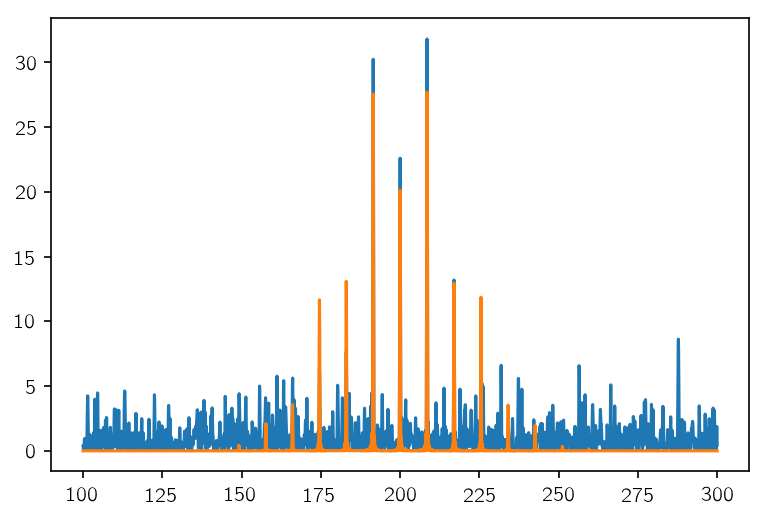

In [8]:
m = LombScargle(t, y, yerr)
f, p = m.autopower(minimum_frequency=100, maximum_frequency=300, nyquist_factor=100, normalization="psd")
plt.plot(f, p);

m = LombScargle(t, session.run(model_y), yerr)
f, p = m.autopower(minimum_frequency=100, maximum_frequency=300, nyquist_factor=100, normalization="psd")
plt.plot(f, p);

In [9]:
from helpers import TFModel
model = TFModel(log_prob, var_list)
model.setup(session)

In [10]:
# We'll use the inverse Hessian to estimate the initial scales of the problem
hess = session.run(tf.hessians(log_prob, var_list))
var = 1.0 / np.abs(np.concatenate([np.diag(np.atleast_2d(h)) for h in hess]))

In [11]:
import hemcee

metric = hemcee.metric.DenseMetric(np.diag(var))

sampler = hemcee.NoUTurnSampler(model.value, model.gradient, metric=metric)

q, lp = sampler.run_warmup(model.current_vector(), 10000)

initial warm up: step_size: 2.8e-01; mean(accept_stat): 0.495: 100%|██████████| 100/100 [00:13<00:00,  7.10it/s]
warm up 1/9: step_size: 2.9e-01; mean(accept_stat): 0.475: 100%|██████████| 25/25 [00:03<00:00,  6.97it/s]
warm up 2/9: step_size: 8.2e-03; mean(accept_stat): 0.417: 100%|██████████| 25/25 [00:02<00:00,  7.12it/s]
warm up 3/9: step_size: 8.0e-03; mean(accept_stat): 0.465: 100%|██████████| 50/50 [00:06<00:00,  6.97it/s]
warm up 4/9: step_size: 1.7e-02; mean(accept_stat): 0.479: 100%|██████████| 100/100 [00:12<00:00,  8.80it/s]
warm up 5/9: step_size: 3.1e-02; mean(accept_stat): 0.488: 100%|██████████| 200/200 [00:26<00:00,  6.99it/s]
warm up 6/9: step_size: 6.0e-02; mean(accept_stat): 0.490: 100%|██████████| 400/400 [00:54<00:00,  7.26it/s]
warm up 7/9: step_size: 6.8e-02; mean(accept_stat): 0.494: 100%|██████████| 800/800 [01:52<00:00,  6.76it/s]
warm up 8/9: step_size: 1.2e-01; mean(accept_stat): 0.496: 100%|██████████| 1600/1600 [03:45<00:00,  7.08it/s]
warm up 9/9: step_s

In [12]:
metric.sample_p()

array([ 1.22261633e+01, -8.09851786e+02, -4.22266824e+02,  3.09955795e+01,
        1.04897917e+00, -1.63416651e+00,  1.30129976e-01, -2.58172117e+00,
        3.98295400e-01,  3.63560315e-01,  7.23718429e-02,  3.69339460e-01,
       -3.55020655e-01, -1.40759903e+00,  4.95575545e-01,  1.78767989e+00,
        2.22123220e+00,  2.93146997e-01,  1.25258633e+00, -6.91290500e-01,
       -3.16568288e+00,  2.41766996e+00, -6.90567435e-01, -7.01938572e-01,
       -1.02443945e+00,  4.99743111e-01,  7.62390459e-01, -6.02306155e-01,
        1.09376013e+00,  5.20752960e-02,  5.88211636e-01,  3.07583312e-01,
        3.04187313e+00, -5.82424482e-02, -3.16303293e+00, -1.41896702e+03])

In [13]:
nuts = sampler.run_mcmc(q, 10000)

step_size: 1.0e-01; mean(accept_stat): 0.506: 100%|██████████| 10000/10000 [21:54<00:00,  7.61it/s]


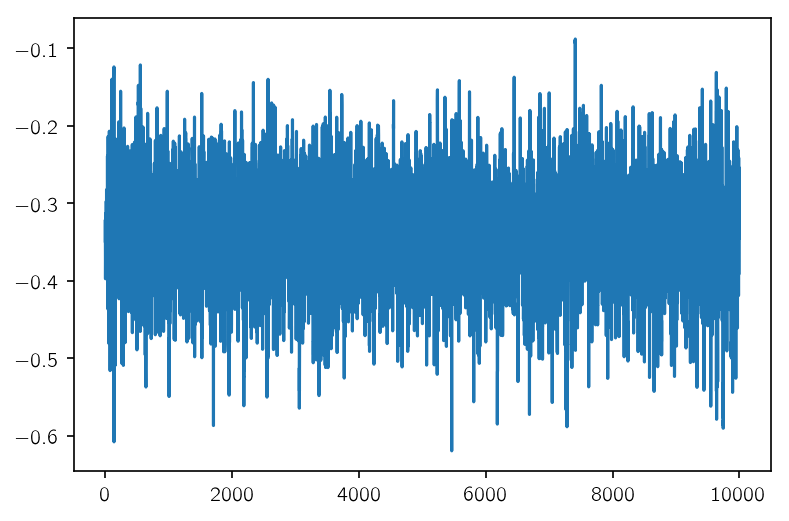

In [14]:
plt.plot(nuts[0][:, 0]);

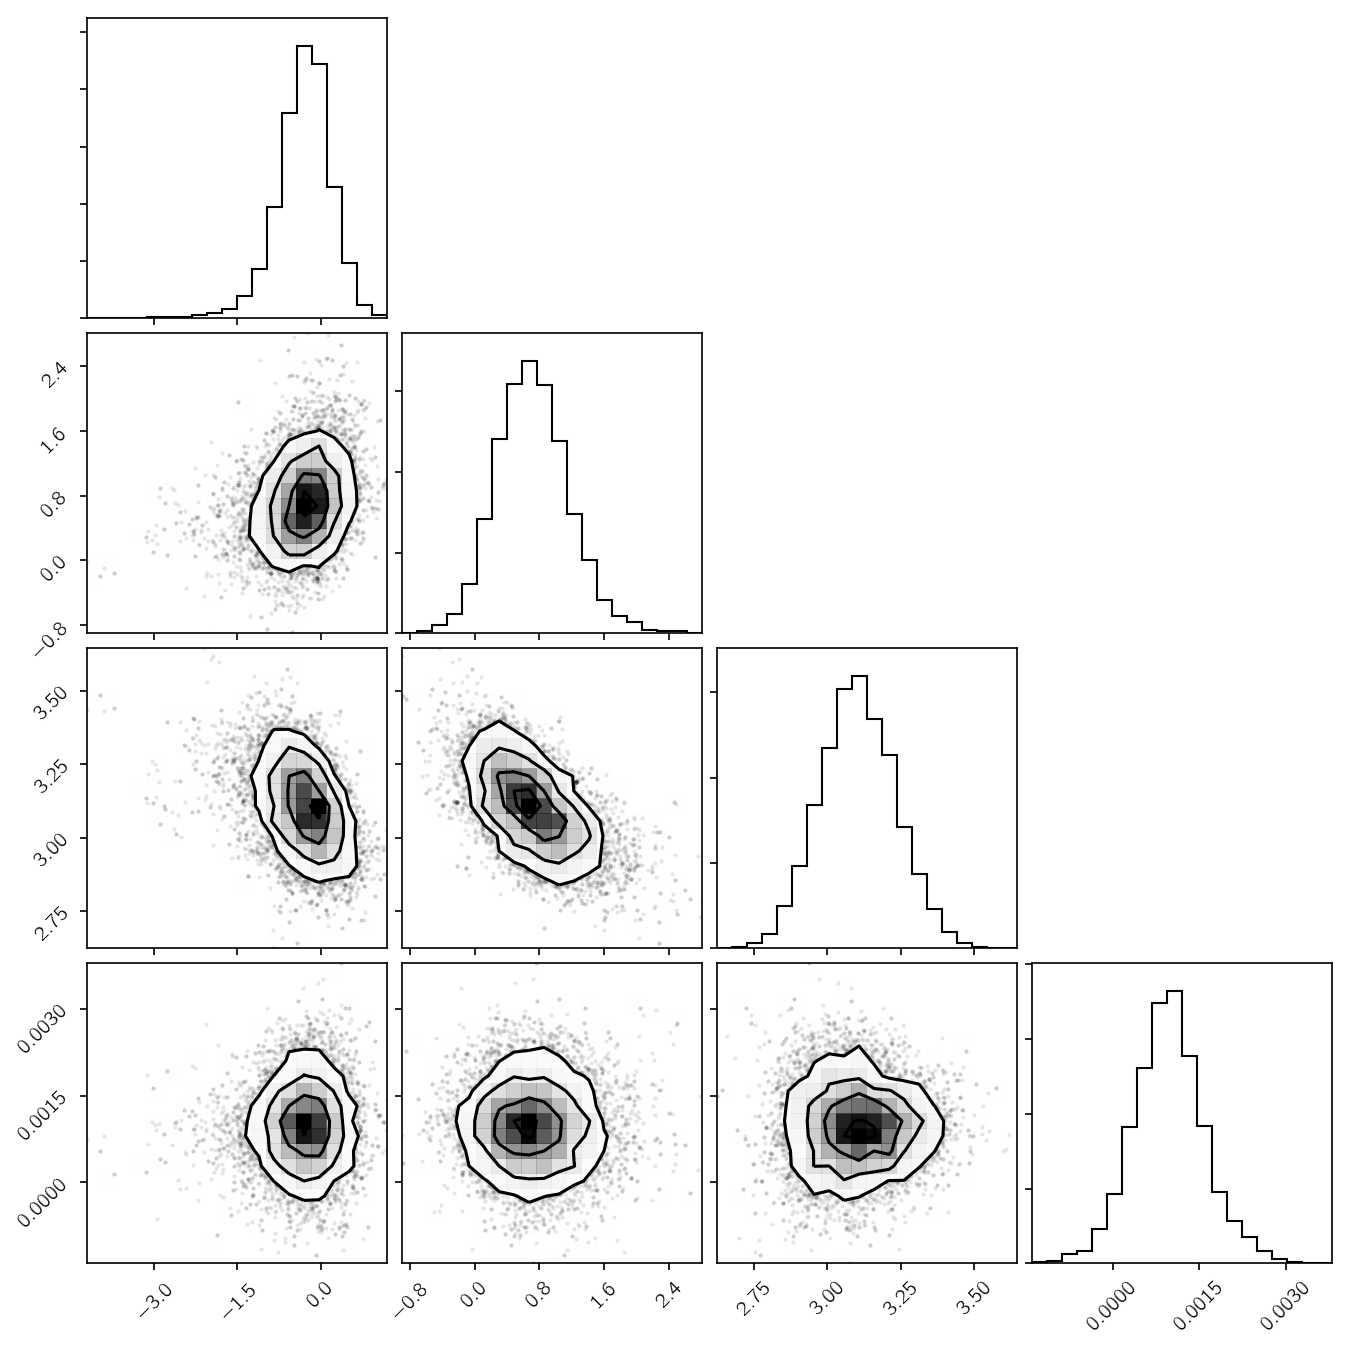

In [18]:
import corner
corner.corner(nuts[0][:, -4:]);

In [19]:
chain = nuts[0]

In [20]:
from emcee.autocorr import integrated_time
tau_nuts = integrated_time(chain[:, None, :])
neff_nuts = len(chain) / np.mean(tau_nuts)
tau_nuts, neff_nuts

(array([3.59653867, 3.43123369, 4.49864571, 5.33395101, 3.79353432,
        4.19920607, 4.28750056, 4.88206985, 5.22045511, 4.16576853,
        3.50347527, 4.1963927 , 4.08513981, 4.48864489, 6.98557899,
        5.11238819, 4.84817519, 2.65938465, 3.39876465, 5.93145029,
        4.69939891, 5.17000742, 4.6195429 , 4.68672517, 3.61576611,
        4.52661427, 5.03227322, 4.98292115, 5.63824118, 5.04346243,
        3.88740359, 3.06365608, 3.863213  , 3.54252259, 4.01256001,
        5.71987885]), 2239.885725339826)

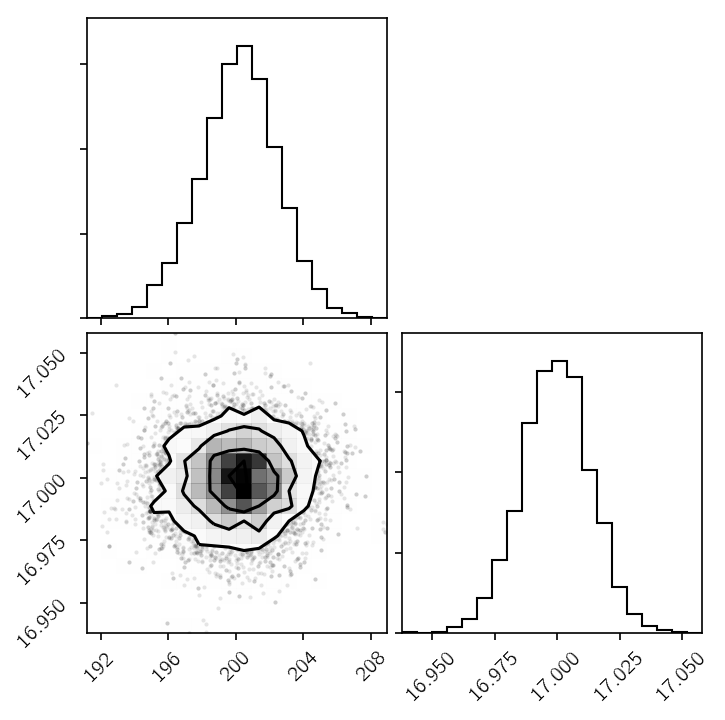

In [24]:
nu_max_value = np.exp(get_value_for_param(nuts[0][:, 0], *log_numax_range))
dnu_value = np.exp(get_value_for_param(nuts[0][:, 3], *log_dnu_range))

corner.corner(np.vstack((nu_max_value, dnu_value)).T);